# 09. Pytorch Model Deployment

## 0. Getting Setup

In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/media/etudiant/New D/PyTorchSRC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# Make our device hardward agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using {device} device.")

[INFO] Using cpu device.


## 1. Getting Data

The dataset we're going to use for deployement is Food-101 dataset. It is a dataset containing 101000 images of food items, organized in 101 categories. The dataset is divided into two main folders: one for the training set and one for the test set. Each of these folders contains 101 subfolders, each one corresponding to a category. Each subfolder contains the images of the corresponding category. The images are in jpg format and have a resolution of 512x512 pixels. The dataset is available for download at the following link: https://www.kaggle.com/dansbecker/food-101

But now we will use a smaller version of the dataset, which contains only 3 categories: pizza, steak and sushi. The dataset is available for download at the following link: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip

In [10]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [12]:
# Setup training and testing data paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini : Model Deployement

### 3 questions to ask before building a model :
1. What is my most ideal machine learning model deployment scenario?
2. WHere is mu model going good?
3. How is my model going function in the real world?

#### 1. What is my most ideal machine learning model deployment scenario?
- **Scenario 1**: Model deployed on a smart phone
- **Scenario 2**: Model deployed on a web application
- **Scenario 3**: Model deployed on a server in the cloud

#### 2. Where is my model going to be used?
- **Location 1**: On a smart phone
- **Location 2**: On a web application
- **Location 3**: On a server in the cloud

#### 3. How is my model going to function in the real world?
- **Function 1**: Model is going to be used for real-time inference
- **Function 2**: Model is going to be used for batch inference
- **Function 3**: Model is going to be used for training other models


**FoodVision Mini ideal use case**: A model deployed on a web application for real-time inference.

1. Performs well: 95%+ accuracy on test set
2. Fast: Makes predictions in under 100ms (including pre and post processing) on a CPU or GPU (mobile phone or computer)

## 3. Creating an EfficientNetB3 extraction model

Feature extraction involves taking the pre-trained patterns a model has learned from another dataset and applying it to our own problem.

We can use the `torchvision` library to access a range of pre-trained models. In this case, we'll use the EfficientNet family of models.

EfficientNet is a family of convolutional neural networks that have been trained on ImageNet (a large dataset of images). The EfficientNet models are known for their efficiency and accuracy. We can use the pre-trained EfficientNet models to extract features from our own images.

EfficientNetB3 pretrained model is available in : https://pytorch.org/vision/stable//models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.efficientnet_b3

In [14]:
import torchvision

# 1. Setup pretrained EfficientNetB3 weights
efficientb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT

# 2. Get EfficientNetB3 transforms
efficientb3_transforms = efficientb3_weights.transforms()

# 3. Setup pretrained EfficientNetB3 model
efficientb3_model = torchvision.models.efficientnet_b3(weights=efficientb3_weights)

# 4. Freeze all layers in the base model
for param in efficientb3_model.parameters():
    param.requires_grad = False

In [15]:
efficientb3_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [18]:
# Get the summary of the model
from torchinfo import summary

# summary(efficientb3_model, input_size=(1, 3, 224, 224))


In [19]:
efficientb3_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [22]:
efficientb3_model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features=1536, out_features=3, bias=True)
)

efficientb3_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### 3.1 Creating a function to make an EfficientNetB3 model

In [45]:
def create_efficientnetb3_model(num_classes: int = 3):
    """Creates an instance of EfficientNetB3 model with a custom final layer.

    Args:
        num_classes (int): Number of classes in the final layer of the model. Defaults to 3.

    Returns:
        nn.Module: A customised version of the EfficientNetB3 model with a custom final layer.
        Transforms: Image transformations to be used with the model.
    """

    # 1. Setup pretrained EfficientNetB3 weights
    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT

    # 2. Get EfficientNetB3 transforms
    transforms = weights.transforms()

    # 3. Setup pretrained EfficientNetB3 model
    mdoel = torchvision.models.efficientnet_b3(weights=weights)

    # 4. Freeze all layers in the base model
    for param in mdoel.parameters():
        param.requires_grad = False

    # 5. Change the final layer to output `num_classes` classes
    mdoel.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )

    return mdoel, transforms

In [46]:
efficientb3_model, efficientb3_transforms = create_efficientnetb3_model(num_classes=3)

efficientb3_transforms

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating a DataLoader using the EfficientNetB3 model's transforms

In [47]:
from going_modular import data_setup

# Define the training and testing dataloaders
train_data, test_data, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=efficientb3_transforms,
                                                       batch_size=32)

In [48]:
len(train_data), len(test_data), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EfficientNetB3 model

In [49]:
# compile the model
efficientb3_model_compiled = torch.compile(efficientb3_model)

In [59]:
from going_modular import engine

# Set random seed
set_seeds(seed=42)

# Create a model, specify the device (GPU) and number of classes
efficientb3_model = efficientb3_model.to(device)

# Create an optimizer and loss function
optimizer = torch.optim.Adam(efficientb3_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
history = engine.train(model=efficientb3_model,
                              train_dataloader=train_data,
                              test_dataloader=test_data,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=50,
                              device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:52<42:57, 52.60s/it]

Epoch: 1 | train_loss: 0.3590 | train_acc: 0.9250 | test_loss: 0.3271 | test_acc: 0.9659


  4%|▍         | 2/50 [01:51<45:05, 56.36s/it]

Epoch: 2 | train_loss: 0.3023 | train_acc: 0.9458 | test_loss: 0.2876 | test_acc: 0.9784


  6%|▌         | 3/50 [02:50<45:14, 57.75s/it]

Epoch: 3 | train_loss: 0.2813 | train_acc: 0.9375 | test_loss: 0.2646 | test_acc: 0.9722


  8%|▊         | 4/50 [03:49<44:35, 58.15s/it]

Epoch: 4 | train_loss: 0.3135 | train_acc: 0.8833 | test_loss: 0.2394 | test_acc: 0.9722


 10%|█         | 5/50 [04:49<43:55, 58.57s/it]

Epoch: 5 | train_loss: 0.2660 | train_acc: 0.9208 | test_loss: 0.2554 | test_acc: 0.9597


 12%|█▏        | 6/50 [05:48<43:12, 58.93s/it]

Epoch: 6 | train_loss: 0.2473 | train_acc: 0.9375 | test_loss: 0.2377 | test_acc: 0.9659


 14%|█▍        | 7/50 [07:06<46:44, 65.22s/it]

Epoch: 7 | train_loss: 0.2981 | train_acc: 0.9250 | test_loss: 0.2223 | test_acc: 0.9659


 16%|█▌        | 8/50 [08:27<49:11, 70.27s/it]

Epoch: 8 | train_loss: 0.3136 | train_acc: 0.9208 | test_loss: 0.2051 | test_acc: 0.9659


 18%|█▊        | 9/50 [09:49<50:23, 73.75s/it]

Epoch: 9 | train_loss: 0.2646 | train_acc: 0.9000 | test_loss: 0.2229 | test_acc: 0.9506


 20%|██        | 10/50 [11:14<51:27, 77.19s/it]

Epoch: 10 | train_loss: 0.2191 | train_acc: 0.9479 | test_loss: 0.1980 | test_acc: 0.9784


 22%|██▏       | 11/50 [12:35<51:01, 78.51s/it]

Epoch: 11 | train_loss: 0.2015 | train_acc: 0.9500 | test_loss: 0.1926 | test_acc: 0.9784


 24%|██▍       | 12/50 [13:55<49:55, 78.83s/it]

Epoch: 12 | train_loss: 0.1782 | train_acc: 0.9604 | test_loss: 0.2003 | test_acc: 0.9631


 26%|██▌       | 13/50 [14:56<45:19, 73.50s/it]

Epoch: 13 | train_loss: 0.2128 | train_acc: 0.9354 | test_loss: 0.1897 | test_acc: 0.9784


 28%|██▊       | 14/50 [15:55<41:31, 69.21s/it]

Epoch: 14 | train_loss: 0.1832 | train_acc: 0.9604 | test_loss: 0.1804 | test_acc: 0.9693


 30%|███       | 15/50 [16:55<38:46, 66.46s/it]

Epoch: 15 | train_loss: 0.1752 | train_acc: 0.9604 | test_loss: 0.1887 | test_acc: 0.9784


 32%|███▏      | 16/50 [17:55<36:31, 64.47s/it]

Epoch: 16 | train_loss: 0.1640 | train_acc: 0.9604 | test_loss: 0.1705 | test_acc: 0.9722


 34%|███▍      | 17/50 [18:57<35:03, 63.74s/it]

Epoch: 17 | train_loss: 0.2274 | train_acc: 0.9396 | test_loss: 0.1707 | test_acc: 0.9722


 36%|███▌      | 18/50 [19:58<33:31, 62.87s/it]

Epoch: 18 | train_loss: 0.1752 | train_acc: 0.9500 | test_loss: 0.1789 | test_acc: 0.9659


 38%|███▊      | 19/50 [21:00<32:19, 62.56s/it]

Epoch: 19 | train_loss: 0.2513 | train_acc: 0.8875 | test_loss: 0.1750 | test_acc: 0.9659


 40%|████      | 20/50 [22:07<31:59, 63.97s/it]

Epoch: 20 | train_loss: 0.2120 | train_acc: 0.9646 | test_loss: 0.1743 | test_acc: 0.9784


 42%|████▏     | 21/50 [23:30<33:35, 69.49s/it]

Epoch: 21 | train_loss: 0.1753 | train_acc: 0.9542 | test_loss: 0.1686 | test_acc: 0.9784


 44%|████▍     | 22/50 [24:42<32:49, 70.33s/it]

Epoch: 22 | train_loss: 0.1838 | train_acc: 0.9396 | test_loss: 0.1729 | test_acc: 0.9659


 46%|████▌     | 23/50 [25:51<31:28, 69.95s/it]

Epoch: 23 | train_loss: 0.1546 | train_acc: 0.9604 | test_loss: 0.1697 | test_acc: 0.9659


 48%|████▊     | 24/50 [26:53<29:15, 67.52s/it]

Epoch: 24 | train_loss: 0.2407 | train_acc: 0.9333 | test_loss: 0.1629 | test_acc: 0.9506


 50%|█████     | 25/50 [27:53<27:13, 65.36s/it]

Epoch: 25 | train_loss: 0.1451 | train_acc: 0.9750 | test_loss: 0.1670 | test_acc: 0.9756


 52%|█████▏    | 26/50 [29:07<27:07, 67.81s/it]

Epoch: 26 | train_loss: 0.1509 | train_acc: 0.9729 | test_loss: 0.1563 | test_acc: 0.9784


 54%|█████▍    | 27/50 [30:22<26:48, 69.93s/it]

Epoch: 27 | train_loss: 0.1959 | train_acc: 0.9292 | test_loss: 0.1469 | test_acc: 0.9659


 56%|█████▌    | 28/50 [31:26<25:02, 68.31s/it]

Epoch: 28 | train_loss: 0.2149 | train_acc: 0.8917 | test_loss: 0.1722 | test_acc: 0.9540


 58%|█████▊    | 29/50 [32:27<23:05, 65.98s/it]

Epoch: 29 | train_loss: 0.2640 | train_acc: 0.9146 | test_loss: 0.1752 | test_acc: 0.9449


 60%|██████    | 30/50 [33:41<22:51, 68.55s/it]

Epoch: 30 | train_loss: 0.1430 | train_acc: 0.9729 | test_loss: 0.1518 | test_acc: 0.9597


 62%|██████▏   | 31/50 [35:03<22:58, 72.56s/it]

Epoch: 31 | train_loss: 0.1321 | train_acc: 0.9646 | test_loss: 0.1530 | test_acc: 0.9631


 64%|██████▍   | 32/50 [36:10<21:15, 70.83s/it]

Epoch: 32 | train_loss: 0.1715 | train_acc: 0.9500 | test_loss: 0.1490 | test_acc: 0.9631


 66%|██████▌   | 33/50 [37:09<19:04, 67.31s/it]

Epoch: 33 | train_loss: 0.1371 | train_acc: 0.9688 | test_loss: 0.1690 | test_acc: 0.9386


 68%|██████▊   | 34/50 [38:12<17:37, 66.11s/it]

Epoch: 34 | train_loss: 0.1843 | train_acc: 0.9333 | test_loss: 0.1543 | test_acc: 0.9568


 70%|███████   | 35/50 [39:12<16:02, 64.16s/it]

Epoch: 35 | train_loss: 0.1138 | train_acc: 0.9750 | test_loss: 0.1480 | test_acc: 0.9631


 72%|███████▏  | 36/50 [40:27<15:43, 67.36s/it]

Epoch: 36 | train_loss: 0.1124 | train_acc: 0.9792 | test_loss: 0.1477 | test_acc: 0.9631


 74%|███████▍  | 37/50 [41:42<15:06, 69.73s/it]

Epoch: 37 | train_loss: 0.1100 | train_acc: 0.9771 | test_loss: 0.1701 | test_acc: 0.9324


 76%|███████▌  | 38/50 [42:37<13:04, 65.34s/it]

Epoch: 38 | train_loss: 0.1216 | train_acc: 0.9729 | test_loss: 0.1404 | test_acc: 0.9722


 78%|███████▊  | 39/50 [43:33<11:26, 62.45s/it]

Epoch: 39 | train_loss: 0.1316 | train_acc: 0.9729 | test_loss: 0.1494 | test_acc: 0.9631


 80%|████████  | 40/50 [44:28<10:02, 60.22s/it]

Epoch: 40 | train_loss: 0.1255 | train_acc: 0.9708 | test_loss: 0.1511 | test_acc: 0.9631


 82%|████████▏ | 41/50 [45:24<08:50, 58.94s/it]

Epoch: 41 | train_loss: 0.1056 | train_acc: 0.9771 | test_loss: 0.1514 | test_acc: 0.9477


 84%|████████▍ | 42/50 [46:19<07:42, 57.83s/it]

Epoch: 42 | train_loss: 0.2296 | train_acc: 0.9437 | test_loss: 0.1545 | test_acc: 0.9693


 86%|████████▌ | 43/50 [47:15<06:41, 57.34s/it]

Epoch: 43 | train_loss: 0.1878 | train_acc: 0.9417 | test_loss: 0.1601 | test_acc: 0.9415


 88%|████████▊ | 44/50 [48:11<05:40, 56.79s/it]

Epoch: 44 | train_loss: 0.1098 | train_acc: 0.9750 | test_loss: 0.1611 | test_acc: 0.9540


 90%|█████████ | 45/50 [49:06<04:41, 56.30s/it]

Epoch: 45 | train_loss: 0.1155 | train_acc: 0.9688 | test_loss: 0.1347 | test_acc: 0.9722


 92%|█████████▏| 46/50 [50:01<03:43, 55.81s/it]

Epoch: 46 | train_loss: 0.1089 | train_acc: 0.9771 | test_loss: 0.1495 | test_acc: 0.9540


 94%|█████████▍| 47/50 [50:56<02:46, 55.64s/it]

Epoch: 47 | train_loss: 0.1076 | train_acc: 0.9833 | test_loss: 0.1352 | test_acc: 0.9631


 96%|█████████▌| 48/50 [51:51<01:50, 55.46s/it]

Epoch: 48 | train_loss: 0.1261 | train_acc: 0.9729 | test_loss: 0.1517 | test_acc: 0.9386


 98%|█████████▊| 49/50 [52:40<00:53, 53.67s/it]

Epoch: 49 | train_loss: 0.1180 | train_acc: 0.9875 | test_loss: 0.1351 | test_acc: 0.9722


100%|██████████| 50/50 [53:32<00:00, 64.24s/it]

Epoch: 50 | train_loss: 0.1706 | train_acc: 0.9542 | test_loss: 0.1422 | test_acc: 0.9631


### 3.4 Inspect the model's training history

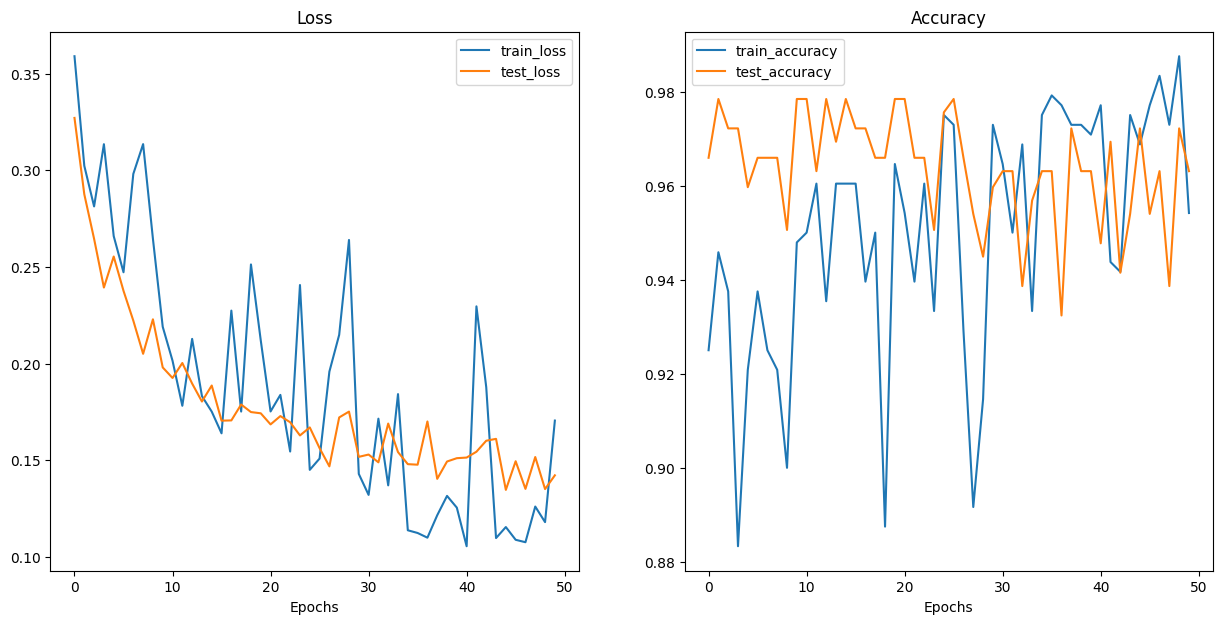

In [60]:
from helper_functions import plot_loss_curves
efficientb3_history = history
plot_loss_curves(efficientb3_history)

### 3.5 Save our model

In [61]:
import os

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

torch.save(efficientb3_model.state_dict(), "models/efficientnetb3_model_50.pt")

### 3.6 Inspecting the size of the model

In [58]:
# Get the size of the model
import os

model_path = "models/efficientnetb3_model.pt"
model_size = os.path.getsize(model_path) / 1e6
print(f"Model size: {model_size} MB")   


Model size: 43.35784 MB


In [62]:
# Get the size of the model
import os

model_path = "models/efficientnetb3_model_50.pt"
model_size = os.path.getsize(model_path) / 1e6
print(f"Model size: {model_size} MB")   

Model size: 43.35983 MB


## 4. Creating a ViT model

In [65]:
vit = torchvision.models.vit_b_32()

vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [66]:
def create_vit_model(num_classes: int = 3):
    """Creates an instance of Vision Transformer (ViT) model with a custom final layer.

    Args:
        num_classes (int): Number of classes in the final layer of the model. Defaults to 3.

    Returns:
        nn.Module: A customised version of the Vision Transformer (ViT) model with a custom final layer.

    """

    # Create ViT_B_32 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_32_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_32(weights=weights)

    # Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # Change the final layer to output num_classes classes
    model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                          out_features=num_classes, 
                                          bias=True))
    
    return model, transforms


In [67]:
vit, vit_transforms = create_vit_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /home/etudiant/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:51<00:00, 6.86MB/s] 


In [74]:
# Get the summary of the model
from torchinfo import summary

# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
#         col_width=18,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT model

In [78]:
# Setup ViT DataLoaders

from going_modular import data_setup

# Define the training and testing dataloaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=vit_transforms,
                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train the ViT model

In [ ]:
from going_modular import engine

# Set random seed
set_seeds(seed=42)

# Create a model, specify the device (GPU) and number of classes
vit = vit.to(device)

# Create an optimizer and loss function
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
history_vit = engine.train(model=vit,
                              train_dataloader=train_dataloader_vit,
                              test_dataloader=test_dataloader_vit,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=device)

 10%|█         | 1/10 [00:22<03:26, 22.97s/it]

Epoch: 1 | train_loss: 0.7155 | train_acc: 0.7333 | test_loss: 0.3051 | test_acc: 0.9290


 20%|██        | 2/10 [00:45<03:01, 22.68s/it]

Epoch: 2 | train_loss: 0.2749 | train_acc: 0.9042 | test_loss: 0.2083 | test_acc: 0.9443


 30%|███       | 3/10 [01:06<02:32, 21.80s/it]

Epoch: 3 | train_loss: 0.1876 | train_acc: 0.9500 | test_loss: 0.1650 | test_acc: 0.9506


 40%|████      | 4/10 [01:29<02:13, 22.24s/it]

Epoch: 4 | train_loss: 0.1456 | train_acc: 0.9625 | test_loss: 0.1518 | test_acc: 0.9625


 50%|█████     | 5/10 [01:52<01:52, 22.55s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9667 | test_loss: 0.1404 | test_acc: 0.9534


 60%|██████    | 6/10 [02:18<01:35, 23.77s/it]

Epoch: 6 | train_loss: 0.1419 | train_acc: 0.9375 | test_loss: 0.1297 | test_acc: 0.9688
